# 5-3,损失函数losses

一般来说，监督学习的目标函数由损失函数和正则化项组成。(Objective = Loss + Regularization)

Pytorch中的损失函数一般在训练模型时候指定。

注意Pytorch中内置的损失函数的参数和tensorflow不同，是y_pred在前，y_true在后，而Tensorflow是y_true在前，y_pred在后。

对于回归模型，通常使用的内置损失函数是均方损失函数nn.MSELoss 。

对于二分类模型，通常使用的是二元交叉熵损失函数nn.BCELoss (输入已经是sigmoid激活函数之后的结果) 
或者 nn.BCEWithLogitsLoss (输入尚未经过nn.Sigmoid激活函数) 。

对于多分类模型，一般推荐使用交叉熵损失函数 nn.CrossEntropyLoss。
(y_true需要是一维的，是类别编码。y_pred未经过nn.Softmax激活。) 

此外，如果多分类的y_pred经过了nn.LogSoftmax激活，可以使用nn.NLLLoss损失函数(The negative log likelihood loss)。
这种方法和直接使用nn.CrossEntropyLoss等价。

如果有需要，也可以自定义损失函数，自定义损失函数需要接收两个张量y_pred，y_true作为输入参数，并输出一个标量作为损失函数值。

Pytorch中的正则化项一般通过自定义的方式和损失函数一起添加作为目标函数。

如果仅仅使用L2正则化，也可以利用优化器的weight_decay参数来实现相同的效果。


## 一，内置损失函数

内置的损失函数一般有类的实现和函数的实现两种形式。

如：nn.BCE 和 F.binary_cross_entropy 都是二元交叉熵损失函数，前者是类的实现形式，后者是函数的实现形式。

实际上类的实现形式通常是调用函数的实现形式并用nn.Module封装后得到的。

一般我们常用的是类的实现形式。它们封装在torch.nn模块下，并且类名以Loss结尾。

常用的一些内置损失函数说明如下。

* nn.MSELoss（均方误差损失，也叫做L2损失，用于回归）

* nn.L1Loss （L1损失，也叫做绝对值误差损失，用于回归）

* nn.SmoothL1Loss (平滑L1损失，当输入在-1到1之间时，平滑为L2损失，用于回归)

* nn.BCELoss (二元交叉熵，用于二分类，输入已经过nn.Sigmoid激活，对不平衡数据集可以用weigths参数调整类别权重)

* nn.BCEWithLogitsLoss (二元交叉熵，用于二分类，输入未经过nn.Sigmoid激活)

* nn.CrossEntropyLoss (交叉熵，用于多分类，要求label为稀疏编码，输入未经过nn.Softmax激活，对不平衡数据集可以用weigths参数调整类别权重)

* nn.NLLLoss (负对数似然损失，用于多分类，要求label为稀疏编码，输入经过nn.LogSoftmax激活)

* nn.KLDivLoss (KL散度损失，也叫相对熵，等于交叉熵减去信息熵，用于标签为概率值的多分类，要求输入经过nn.LogSoftmax激活)

* nn.CosineSimilarity(余弦相似度，可用于多分类)

* nn.AdaptiveLogSoftmaxWithLoss (一种适合非常多类别且类别分布很不均衡的损失函数，会自适应地将多个小类别合成一个cluster)

重点介绍一下 二元交叉熵、多元交叉熵、对数损失LogLoss、负对数似然损失NLLLoss、KL散度之间的区别和联系。

**1，二分类的交叉熵的计算公式是什么？为什么是这样一种形式？**

$$
BinaryCrossEntropyLoss(Y,\hat{Y}) = - \frac{1}{N}\sum_{i=0}^{N-1} (y_i log \hat{y_i} + (1-y_i) log(1-\hat{y_i}))
$$


该公式由极大似然原理推导得来。由于 $\hat{y_i}$表示的是样本标签为1的概率， $1-\hat{y_i}$表示的是样本标签为0的概率，
那么训练集中的全部样本取得对应标签的概率即似然函数可以写成如下形式

$$
L(Y,\hat{Y}) = \prod_{i=0}^{N-1} \hat{y_i}^{y_i} (1-\hat{y_i})^{(1-y_i)}
$$

注意当$y_i = 1$为时，连乘中的项为 $\hat{y_i}$，当$y_i = 0$为时，连乘中的项为 $(1-\hat{y_i})$、


转换成对数似然函数，得到 

$$
lnL(Y,\hat{Y}) = \sum_{i=0}^{N-1} y_i ln{\hat{y_i}} + (1-y_i)ln{(1-\hat{y_i})} 
$$

对数似然函数求极大值，等价于对对数似然函数的负数求极小值，考虑样本数量维度归一化，于是得到了二元交叉熵损失函数的形式。





**2，多元交叉熵的计算公式是什么？和二元交叉熵有什么联系?**


$$
CrossEntropyLoss(Y,\hat{Y}) = - \frac{1}{N}\sum_{i=0}^{N-1} \sum_{k=0}^{K-1} I(y_i==k) log \hat{y_{i,k}} \\
\text{where} I(x) \text{ is the Indicator function} \\
I(True)= 1 \text{ and } I(False) = 0
$$

多元交叉熵是二元交叉熵的自然拓展，其中$y_i$取0~K-1其中的一个类别编码序号，$\hat{y_i}$ 是一个长度为K的概率向量。多元交叉熵的类别数K取2时即可得到二元交叉熵对应的公式。


**3，sklearn，catboost等库中常常看到logloss对数损失函数，这个损失函数如何计算，和交叉熵有什么关系？**

$$
LogLoss(Y,\hat{Y}) = - \frac{1}{N}\sum_{i=0}^{N-1}  log(\hat{y_{i}}[y_i])
$$

公式中的方括号和Python中的索引的用法一致，表示取$\hat{y_{i}}$ 的第$y_i$个元素。

容易证明，对数损失函数与交叉熵函数完全等价，是交叉熵的另外一种视角: 即每个样本对其标签对应类别的预测概率值求对数，求平均再取负数即可。


**4，pytorch中的 nn.NLLLoss 和 nn.CrossEntropyLoss有什么区别和联系？**

NLLoss 全称是 Negative Log Likelihood Loss，即 负对数似然损失。其计算公式如下

$$
NLLoss(Y,\hat{Z}) = - \frac{1}{N}\sum_{i=0}^{N-1}  {z_{i}}[y_i]
$$

公式中的方括号和Python中的索引的用法一致，表示取$\hat{z_{i}}$ 的第$y_i$个元素。

注意的是这里的$\hat{Z}$实际上不是概率值，而是概率值取了对数，所以，和LogLoss一对比，很容易发现，LogSoftmax+NLLLoss 等价于 Softmax+LogLoss,等价于 Softmax+CrossEntropyLoss。为了数值精度考虑，pytorch中的nn.CrossEntropyLoss要求输入未经过Softmax激活，所以有 nn.LogSoftmax+nn.NLLLoss 等价于 nn.CrossEntropyLoss.


**5，KL散度的计算公式是什么？有什么现实含义？和交叉熵有什么关系？**

KL散度也叫相对熵，可以衡量两个概率分布之间的差异。

KL散度的计算公式是交叉熵减去信息熵。注意KL散度是不对称的, 即$KL(P,Q)\neq KL(Q,P)$, 所以不能够叫做KL距离。

两个随机变量P和Q之间的KL散度定义如下：
$$
KL(P,Q) = \sum_{k=0}^{K-1}p_k ln(\frac{p_k}{q_k}) = \sum_{k=0}^{K-1} p_k (ln{p_k} - ln{q_k})
$$

对二分类情况下，有：

$$
KL(Y,\hat{Y}) = - \frac{1}{N}\sum_{i=0}^{N-1} (y_i log \hat{y_i} + (1-y_i) log(1-\hat{y_i}))  + \frac{1}{N}\sum_{i=0}^{N-1} (y_i log y_i + (1-y_i) log(1- y_i))
$$

在$y_i$取0或1的情况下，信息熵部分为0，所以KL散度就等于交叉熵，但是在一些情况下，例如使用标签平滑处理技术后，$y_i$的取值不是0或1，这时候，KL散度相当于在交叉熵的基础上减去了一个常数，KL散度作为损失函数去优化模型的效果和交叉熵是完全一样的，但是在这种情况下当模型完美拟合标签的情况下KL散度的最小值可取到0，而此时交叉熵能够取到的最小值是信息熵不为0，所以这种情况下使用KL散度更符合我们对Loss的一般认识。


In [1]:
import numpy as np
import pandas as pd
import torch 
from torch import nn 
import torch.nn.functional as F 

# nn.BCELoss() 和 nn.BCEWithLogitsLoss() 关系

y_pred = torch.tensor([5.0,3,10,-5,-3,-10.0])
y_true = torch.tensor([1.0,1,1,0,0,0])

bce = nn.BCELoss()(torch.sigmoid(y_pred),y_true)
print(bce)


bce_logits = nn.BCEWithLogitsLoss()(y_pred,y_true)
print(bce_logits)


tensor(0.0184)
tensor(0.0184)


In [2]:
# nn.CrossEntropyLoss() 和  nn.NLLLoss() 关系

y_pred = torch.tensor([[10.0,0.0,-10.0],[8.0,8.0,8.0]])
y_true = torch.tensor([0,2])

# 直接调用交叉熵损失
ce = nn.CrossEntropyLoss()(y_pred,y_true)
print(ce)

# 等价于先计算nn.LogSoftmax激活，再调用nn.NLLLoss
y_pred_logsoftmax = nn.LogSoftmax(dim = 1)(y_pred)
nll = nn.NLLLoss()(y_pred_logsoftmax,y_true)
print(nll)


tensor(0.5493)
tensor(0.5493)


In [3]:
# nn.CrossEntropyLoss() 和  KLDivLoss 关系
import torch.nn.functional as F 

y_pred = torch.tensor([[10.0,0.0,-10.0],[8.0,8.0,8.0]],requires_grad=True)
y_true = torch.tensor([0,2])

ce = nn.CrossEntropyLoss(reduction="mean")(y_pred,y_true)
print(ce)


#KLDivLoss要求target为向量形式编码且preds经过LogSoftmax激活
pred = F.log_softmax(y_pred,dim=1)
target = F.one_hot(y_true).float()
kl = nn.KLDivLoss(reduction="batchmean")(pred,target)
print(kl)

tensor(0.5493, grad_fn=<NllLossBackward0>)
tensor(0.5493, grad_fn=<DivBackward0>)


## 二，自定义损失函数

自定义损失函数接收两个张量y_pred,y_true作为输入参数，并输出一个标量作为损失函数值。

也可以对nn.Module进行子类化，重写forward方法实现损失的计算逻辑，从而得到损失函数的类的实现。

下面演示两个比较著名的范例。

### 1，自定义损失函数之FocalLoss范例

下面是一个Focal Loss的自定义实现示范。Focal Loss是一种对binary_crossentropy的改进损失函数形式。

它在样本不均衡和存在较多易分类的样本时相比binary_crossentropy具有明显的优势。

它有两个可调参数，alpha参数和gamma参数。其中alpha参数主要用于衰减负样本的权重，gamma参数主要用于衰减容易训练样本的权重。

从而让模型更加聚焦在正样本和困难样本上。这就是为什么这个损失函数叫做Focal Loss。

详见《5分钟理解Focal Loss与GHM——解决样本不平衡利器》

https://zhuanlan.zhihu.com/p/80594704

$$focal\_loss(y,p) = 
\begin{cases} -\alpha (1-p)^{\gamma}\log(p) & \text{if y = 1}\\
-(1-\alpha) p^{\gamma}\log(1-p) & \text{if y = 0} 
\end{cases}$$

In [4]:
import torch 
from torch import nn 
class FocalLoss(nn.Module):

    def __init__(self,gamma=2.0,alpha=0.75):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self,y_pred,y_true):
        bce = torch.nn.BCELoss(reduction = "none")(y_pred,y_true)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = torch.pow(1.0 - p_t, self.gamma)
        loss = torch.mean(alpha_factor * modulating_factor * bce)
        return loss
    
    
    

In [5]:
#困难样本
y_pred_hard = torch.tensor([[0.5],[0.5]])
y_true_hard = torch.tensor([[1.0],[0.0]])

#容易样本
y_pred_easy = torch.tensor([[0.9],[0.1]])
y_true_easy = torch.tensor([[1.0],[0.0]])

focal_loss = FocalLoss()
bce_loss = nn.BCELoss()


print("focal_loss(easy samples):", focal_loss(y_pred_easy,y_true_easy))
print("bce_loss(easy samples):", bce_loss(y_pred_easy,y_true_easy))

print("focal_loss(hard samples):", focal_loss(y_pred_hard,y_true_hard))
print("bce_loss(hard samples):", bce_loss(y_pred_hard,y_true_hard))


#可见 focal_loss让容易样本的权重衰减到原来的 0.0005/0.1054 = 0.00474
#而让困难样本的权重只衰减到原来的 0.0866/0.6931=0.12496

# 因此相对而言，focal_loss可以衰减容易样本的权重。


focal_loss(easy samples): tensor(0.0005)
bce_loss(easy samples): tensor(0.1054)
focal_loss(hard samples): tensor(0.0866)
bce_loss(hard samples): tensor(0.6931)


FocalLoss的使用完整范例可以参考下面中`自定义L1和L2正则化项`中的范例，该范例既演示了自定义正则化项的方法，也演示了FocalLoss的使用方法。


### 2，SCELoss 

Symmetric Cross Entropy Loss 也是一种对交叉熵损失的改进损失，主要用在标签中存在明显噪声的场景。



$$
sce\_loss(y,p) = \alpha\;ce\_loss(y,p) + \beta\;rce\_loss(y,p)\\
ce\_loss(y,p) = - y log(p) -(1-y) log(1-p) \\
rce\_loss(y,p) = ce\_loss(p,y)  \\
rce\_loss(y,p)= - p log(y) -(1-p) log(1-y) 
$$

其基本思想可以简单描述如下：

当 y是正常标签的时候，y和p较容易取得一致【例如 y=1时，p取到0.8】，这时候 rce与ce的比值相对较大，引入rce可以增加正常标签样本在总Loss中的贡献。

当y时噪声标签的时候，y和p很难取得一致，相当于困难样本 【例如 y=0时，p取到0.8】，这时候rce与ce的比值相对较小，引入rce可以减小噪声标签样本在总Loss中的贡献。



参考文章

《SCE 损失》 https://zhuanlan.zhihu.com/p/420827592

《噪声损失 》https://zhuanlan.zhihu.com/p/420913134


In [6]:
def ce(y,p):
    p = torch.clamp(p,min=1e-4,max=1-1e-4)
    y = torch.clamp(y,min=1e-4,max=1-1e-4)
    return -y*torch.log(p) - (1-y)*torch.log(1-p)

def rce(y,p):
    return ce(p,y)

#正常标签
y = torch.tensor(1.0)
p = torch.tensor(0.8)
print(rce(y,p)/ce(y,p))


#噪声标签
y = torch.tensor(0.0)
p = torch.tensor(0.8)
print(rce(y,p)/ce(y,p))


tensor(8.2502)
tensor(4.5786)


In [7]:
import torch 
from torch import nn
import  torch.nn.functional as F 

class SCELoss(nn.Module):
    def __init__(self, num_classes=10, a=1, b=1):
        super(SCELoss, self).__init__()
        self.num_classes = num_classes
        self.a = a #两个超参数
        self.b = b
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        # CE 部分，正常的交叉熵损失
        ce = self.cross_entropy(pred, labels)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-4, max=1.0)
        label_one_hot = F.one_hot(labels, self.num_classes).float().to(pred.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0) #最小设为 1e-4，即 A 取 -4
        rce = (-1 * torch.sum(pred * torch.log(label_one_hot), dim=1))

        loss = self.a * ce + self.b * rce.mean()
        return loss
    

## 三，L1和L2正则化项

L1正则、L2正则、Dropout、Early_stopping是神经网络常用的正则化方法。




1，L1正则和L2正则的效果有什么差异?为什么？


通常认为L1 正则化可以产生稀疏权值矩阵，即产生一个参数稀疏的模型。

而L2 正则化可以让模型的参数取绝对值较小的数。


考虑两种正则化函数的等值面与原始Loss函数的等值面的关系。

以二维情况为例，L1正则化函数的等值面是个菱形，L2正则化函数的等值面是个圆形。

最优参数必定取在正则化函数的某条等值面和原始Loss函数的某条等值面的切点处。

从求导角度考虑，最优参数是个极值点，要求该处 正则化函数的梯度等于 原始Loss函数的梯度的负数。

而梯度方向必定垂直于等值面的切线方向，所以可以推断必定极值点必定在正则化函数某条等值面和原始Loss函数的某条等值面的切点处。

从数值角度考虑，如果该极值点不在两个等值面的切点，那么沿着原始函数Loss的等值面(原始Loss不变)，一定可以找到一个点正则化函数取值更小。

这样就用反证法证明了最优参数必定取在正则化函数的某条等值面和原始Loss函数的某条等值面的切点处。

由于L1正则化函数的等值面是个菱形，更容易和凸的Loss函数的等值面相切在坐标轴上，所以倾向于取得参数稀疏的模型，而L2正则化则更倾向于使得极小点到坐标原点的距离更近，但不会导致参数稀疏。




![](https://tva1.sinaimg.cn/large/e6c9d24egy1h5q2vhkvz9j20pa0ctjsg.jpg)





参考文章《L1正则化与L2正则化》：https://zhuanlan.zhihu.com/p/35356992 



In [8]:
import torch 
# L2正则化
def L2Loss(model,alpha):
    l2_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name: #一般不对偏置项使用正则
            l2_loss = l2_loss + (0.5 * alpha * torch.sum(torch.pow(param, 2)))
    return l2_loss

# L1正则化
def L1Loss(model,beta):
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l1_loss = l1_loss +  beta * torch.sum(torch.abs(param))
    return l1_loss



## 四，L1L2正则项使用完整范例

下面以一个二分类问题为例，演示给模型的目标函数添加自定义L1和L2正则化项的方法。

这个范例同时演示了以下FocalLoss的使用。

**1，准备数据**

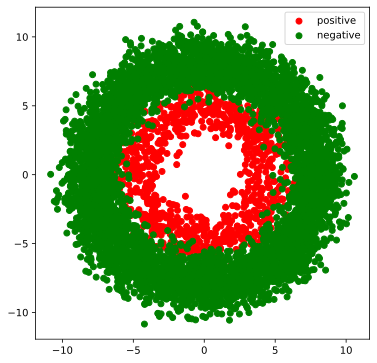

In [9]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 1000,6000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


![](./data/5-3-同心圆分布.png)

In [10]:
ds = TensorDataset(X,Y)

ds_train,ds_val = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=2)
dl_val = DataLoader(ds_val,batch_size = 100,num_workers=2)

features,labels = next(iter(dl_train))


**2，定义模型**

In [11]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y
        
net = Net() 

from torchkeras import summary

summary(net,features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 4]                   12
Linear-2                                     [-1, 8]                   40
Linear-3                                     [-1, 1]                    9
Total params: 61
Trainable params: 61
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000401
--------------------------------------------------------------------------


**3，训练模型**

In [12]:
# L2正则化
def L2Loss(model,alpha):
    l2_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name: #一般不对偏置项使用正则
            l2_loss = l2_loss + (0.5 * alpha * torch.sum(torch.pow(param, 2)))
    return l2_loss

# L1正则化
def L1Loss(model,beta):
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l1_loss = l1_loss +  beta * torch.sum(torch.abs(param))
    return l1_loss


<<<<<< 🐌 cpu is used >>>>>>


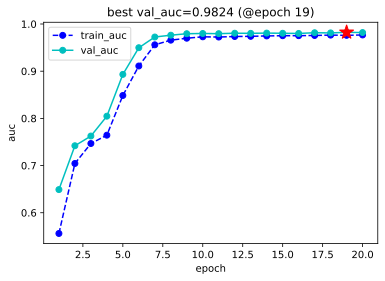

In [13]:
from torchkeras import KerasModel
from torchkeras.metrics import AUC

net = Net()

# 将L2正则和L1正则添加到FocalLoss损失，一起作为目标函数
def focal_loss_with_regularization(y_pred,y_true):
    y_probs = torch.sigmoid(y_pred)
    focal = FocalLoss()(y_probs,y_true) 
    l2_loss = L2Loss(net,0.001) #注意设置正则化项系数
    l1_loss = L1Loss(net,0.001)
    total_loss = focal + l2_loss + l1_loss
    return total_loss


optimizer = torch.optim.Adam(net.parameters(),lr = 0.002)
model = KerasModel(net=net,
                   loss_fn = focal_loss_with_regularization ,
                   metrics_dict = {"auc":AUC()},
                   optimizer= optimizer )


dfhistory = model.fit(train_data=dl_train,
      val_data=dl_val,
      epochs=20,
      ckpt_path='checkpoint',
      patience=3,
      monitor='val_auc',
      mode='max',
      plot=True,
      cpu=True
    )

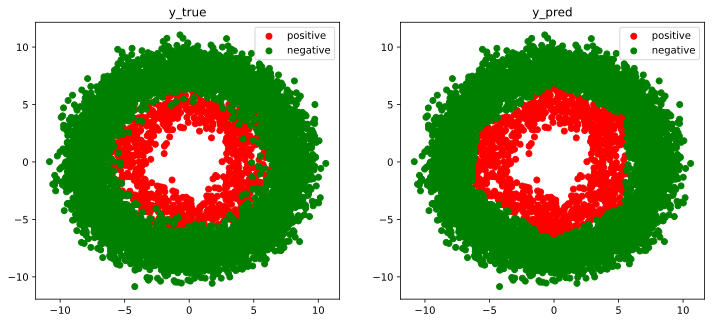

In [14]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(torch.sigmoid(net.forward(X))>=0.5)]
Xn_pred = X[torch.squeeze(torch.sigmoid(net.forward(X))<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


## 五，通过优化器实现L2正则化

如果仅仅需要使用L2正则化，那么也可以利用优化器的weight_decay参数来实现。

weight_decay参数可以设置参数在训练过程中的衰减，这和L2正则化的作用效果等价。

```
before L2 regularization:

gradient descent: w = w - lr * dloss_dw 

after L2 regularization:

gradient descent: w = w - lr * (dloss_dw+beta*w) = (1-lr*beta)*w - lr*dloss_dw

so （1-lr*beta）is the weight decay ratio.
```

Pytorch的优化器支持一种称之为Per-parameter options的操作，就是对每一个参数进行特定的学习率，权重衰减率指定，以满足更为细致的要求。

In [15]:
weight_params = [param for name, param in model.named_parameters() if "bias" not in name]
bias_params = [param for name, param in model.named_parameters() if "bias" in name]

optimizer = torch.optim.SGD([{'params': weight_params, 'weight_decay':1e-5},
                             {'params': bias_params, 'weight_decay':0}],
                            lr=1e-2, momentum=0.9)


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)